Basic SoftMax multiclass regression with default (3, 3) parameter FV on only the MFCC features.

In [1]:
import os
import scipy.io as spio
import numpy as np
from os.path import join, isdir, isfile
%matplotlib inline
import matplotlib.pyplot as plt

DATA_DIR = '../data'
# 'file_name' 'class_name' 'class' 'eng' 'mfc' 'chroma' 't'
# 'keystrength' 'brightness' 'zerocross' 'roughness' 'inharmonic' 'hcdf'
#

In [2]:
FVs = join(DATA_DIR, 'FV.mat')
LBs = join(DATA_DIR, 'LB.mat')
if not isfile(FVs) or not isfile(LBs):
    print('Generating Fisher Vectors')
    !matlab -nodisplay -nosplash -nodesktop -r "run('../tools/FV_concat.m');exit;"
else:
    print('Using existing FVs')

mfcc = np.transpose(spio.loadmat(FVs)['FV'])
labels = spio.loadmat(LBs)['LB'][0]
N = mfcc.shape[0]

p = np.random.permutation(N)
mfcc = mfcc[p]
labels = labels[p]

N

Using existing FVs


1000

In [27]:
trN = int(0.8 * N)
teN = N - trN
trX, trY = mfcc[:trN], labels[:trN]
teX, teY = mfcc[-teN:], labels[-teN:]
len(set(trY))

means = np.mean(trX, axis=0)
stddevs = np.std(trX, axis=0)

def summary(x):
    return '[{:.4f}, {:.4f}]'.format(np.ndarray.min(x), np.ndarray.max(x))
print('means in range', summary(means))
print('std in range', summary(stddevs))

# Whitened data
def adjust(x): return (x - means[None, :]) / stddevs[None, :]
trXadj = adjust(trX)
teXadj = adjust(teX)

print('norm. means in range', summary(np.mean(trXadj, axis=0)))
print('norm. std in range', summary(np.std(trXadj, axis=0)))
trX.shape

means in range [-0.0201, 0.0087]
std in range [0.0201, 0.0624]
norm. means in range [-0.0000, 0.0000]
norm. std in range [1.0000, 1.0000]


(800, 960)

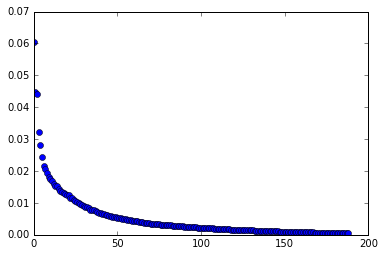

norm. means in range [-0.0000, 0.0000]
norm. std in range [1.0000, 1.0000]


In [29]:
# Note that N < D, which tells us we'd be overfitting without some kind of regularization
from sklearn.decomposition import PCA

pca = PCA(whiten=True, n_components=0.99).fit(trX)
plt.plot(pca.explained_variance_ratio_, 'o')
plt.show()
pcaX = pca.transform(trX)

print('norm. means in range', summary(np.mean(pcaX, axis=0)))
print('norm. std in range', summary(np.std(pcaX, axis=0)))

# But it doesn't look like PCA is appropriate.

In [4]:
# Random-restart softmax
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings('ignore')

reg = LogisticRegressionCV(multi_class='multinomial', solver='lbfgs', max_iter=5000, n_jobs=8)
reg.fit(trX, trY)
print('train data accuracy {} test accuracy {}'.format(reg.score(trX, trY), reg.score(teX, teY)))

train data accuracy 0.735 test accuracy 0.68


In [12]:
reg.fit(trXadj, trY)
print('train data accuracy {} test accuracy {}'.format(reg.score(trXadj, trY), reg.score(teXadj, teY)))

train data accuracy 0.785 test accuracy 0.645


In [31]:
reg.fit(pcaX, trY)
print('train data accuracy {} test accuracy {}'.format(reg.score(pcaX, trY), reg.score(pca.transform(teX), teY)))
# interesting, training went up... try different PCA var exp values.

train data accuracy 0.9025 test accuracy 0.615
